In [2]:
import riversound, glob, obspy, matplotlib, datetime
import numpy as np
import matplotlib.pyplot as plt
import gemlog
import pandas as pd
import matplotlib.ticker as ticker

## run this code if you're using ipython and it doesn't show plot windows
# %matplotlib qt 

## FFT works best when data length is a power of 2, so use this function to help determine window size.
def next_power_2(x):
    return int(2**np.ceil(np.log2(x)))

def reformat(l): # turn list l into a numpy array
    lengths = np.array([len(i) for i in l])
    normal_length = lengths[lengths > 0][0]
    if any((lengths != 0) & (lengths != normal_length)):
        raise ValueError('nonzero lengths of elements of l must all be the same')
    for i in np.where(lengths == 0)[0]:
        l[i] = np.zeros(normal_length)
    return np.array(l)
def interp_times(t_out, t, q):
    t_out = np.array([x.timestamp() for x in t_out])
    t = np.array([x.timestamp() for x in t])
    return np.interp(t_out, t, q)

## define paths containing infrasound and audible data, read in and filter data

path = '/home/scott/bender/gradschool/data/2022_Flume/2022-01-11_Flume/'
path_infrasound = path + ''
path_audible = path + 'AM003/'
infr_files = sorted(glob.glob(path_infrasound + '/*ral.mseed'))
aud_files  = sorted(glob.glob(path_audible + '/*.WAV'))
# for individual files:
mseed_filename = path_infrasound + 'ADB_Chaparral.mseed'
aud_filename = path_audible + '20220111_201203.WAV'


## read in and slice data based on audiomoth timestamp
tr_infrasound_full = obspy.read(mseed_filename)
tr_infrasound_full = tr_infrasound_full[0]
tr_infrasound_full.filter('highpass', freq = 0.05, zerophase = True)
## Download Chaparral response
from obspy.clients.nrl import NRL
nrl = NRL()   
sensor_keys = ['Chaparral Physics', '60Vx']
logger_keys = ['DiGOS/Omnirecs', 'DATACUBE', '1', '800']
chap_response = nrl.get_response(sensor_keys = sensor_keys, datalogger_keys = logger_keys)
## deconvolve it from the infrasound trace
tr_infrasound_full.stats.response = chap_response
tr_infrasound_full.remove_response()

# re-run this everytime you loop
times_infrasound = []
meanspec_list_infrasound = [] 
medspec_list_infrasound = []
power_infrasound = []
times_audible = []
meanspec_list_audible = []
medspec_list_audible = []
power_audible = []
infra_freqs_low = [5]
infra_freqs_high = [25]
infra_power_band_limit = [[] for i in range(len(infra_freqs_low))]
aud_freqs_low = [50]
aud_freqs_high = [500]
aud_power_band_limit = [[] for i in range(len(aud_freqs_low))]

# include all below in loop
for file in aud_files[3:-1]: # [3:-1] makes it work when all .wav files are in path, [3:7] for just experiment 1, [7:-1] for just experiment 2
    tr_audible = riversound.read_audiomoth(file, remove_response = True)
    # trim data for individual files
    t1 = tr_audible.stats.starttime
    t2 = tr_audible.stats.endtime
    tr_infrasound = tr_infrasound_full.slice(t1,t2)
    tr_infrasound = tr_infrasound.filter('highpass', freq = 3, zerophase = True)
    nfft_infrasound = next_power_2(10 / tr_infrasound.stats.delta) # >10-sec windows for freq resolution finer than 0.1 Hz
    nfft_audible = next_power_2(0.1 / tr_audible.stats.delta) # >0.1-sec windows for freq res finer than 10 Hz
    infra_spec_info = riversound.spectrum(tr_infrasound, nfft = nfft_infrasound)
    freqs_infrasound_all = infra_spec_info['freqs']
    medspec_list_infrasound.append(infra_spec_info['median'])
    meanspec_list_infrasound.append(infra_spec_info['mean'])
    power_infrasound.append(np.sum(infra_spec_info['mean']) * np.diff(freqs_infrasound_all)[0]) # integral spec * df

    aud_spec_info = riversound.spectrum(tr_audible, nfft = nfft_audible, kurtosis_threshold = 0.25)
    freqs_audible_all = aud_spec_info['freqs']
    medspec_list_audible.append(aud_spec_info['median'])
    meanspec_list_audible.append(aud_spec_info['mean'])
    power_audible.append(np.sum(aud_spec_info['mean']) * np.diff(aud_spec_info['freqs'])[0])
    print(tr_audible)
    
    times_infrasound.append(t1.datetime)
    times_audible.append(t1.datetime)
    for k in [0]: # audible
            indices_aud = (freqs_audible_all > aud_freqs_low[k]) & (freqs_audible_all < aud_freqs_high[k])
            aud_power_band_limit[k].append(np.sum(aud_spec_info['mean'][indices_aud]) * np.diff(aud_spec_info['freqs'])[0])
    for k in [0]: # change to 0,1,2... for more n bands defined in freqs low and high
            indices_infra = (freqs_infrasound_all > infra_freqs_low[k]) & (freqs_infrasound_all < infra_freqs_high[k])
            infra_power_band_limit[k].append(np.sum(infra_spec_info['mean'][indices_infra]) * np.diff(infra_spec_info['freqs'])[0])

/home/scott/anaconda3/envs/gem/lib/python3.9/site-packages/obspy/clients/nrl/client.py:228: UserWarning: Failed to recalculate overall sensitivity.
  warnings.warn(msg)
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


... | 2022-01-11T21:28:34.000000Z - 2022-01-11T21:32:51.008688Z | 16000.0 Hz, 4112140 samples
... | 2022-01-11T21:36:19.000000Z - 2022-01-11T21:38:32.104688Z | 16000.0 Hz, 2129676 samples
... | 2022-01-11T21:42:54.000000Z - 2022-01-11T21:44:53.792688Z | 16000.0 Hz, 1916684 samples
... | 2022-01-11T21:48:37.000000Z - 2022-01-11T21:58:04.280688Z | 16000.0 Hz, 9076492 samples
... | 2022-01-11T22:02:11.000000Z - 2022-01-11T22:04:22.056688Z | 16000.0 Hz, 2096908 samples
... | 2022-01-11T22:11:12.000000Z - 2022-01-11T22:12:58.480688Z | 16000.0 Hz, 1703692 samples
... | 2022-01-11T22:21:25.000000Z - 2022-01-11T22:22:54.072688Z | 16000.0 Hz, 1425164 samples
... | 2022-01-11T22:24:31.000000Z - 2022-01-11T22:27:11.752688Z | 16000.0 Hz, 2572044 samples


In [ ]:
# Y = np.array(riversound.find_mean_freq(meanspec_audible, freqs_audible, 13))[indices_meanfreq]
# print(Y)
# print((riversound.find_mean_freq(meanspec_audible, freqs_audible, 13)))

interp_times(times_infrasound, t, q)[indices_infra]
#riversound.find_mean_freq(meanspec_infrasound[indices_infra], freqs_infrasound[indices_infra])

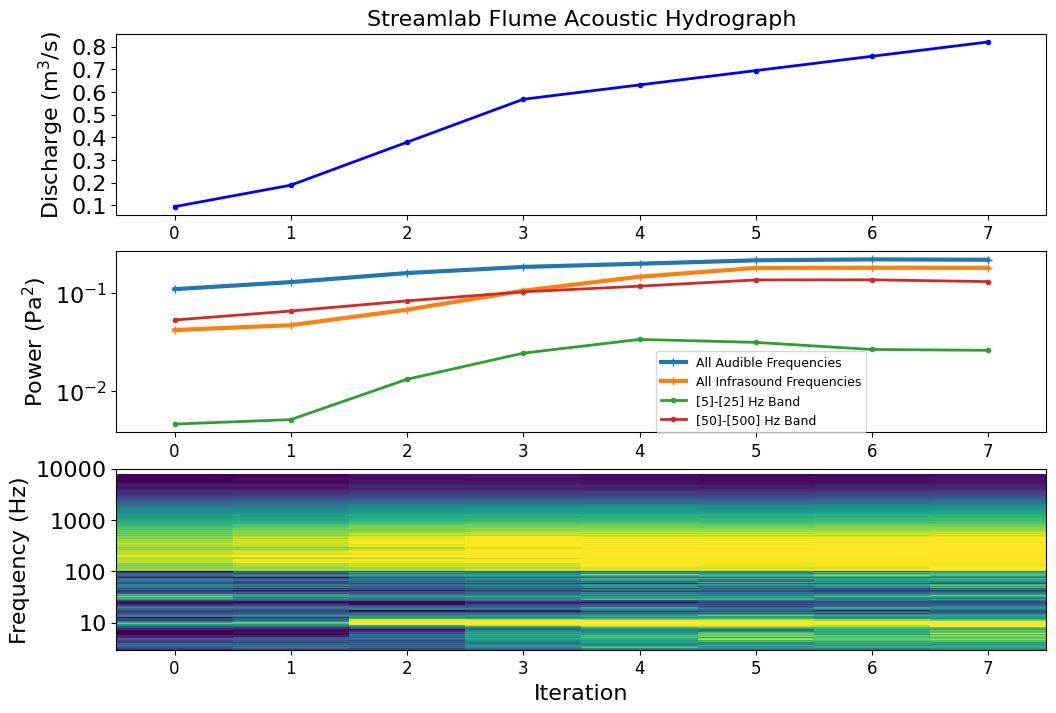

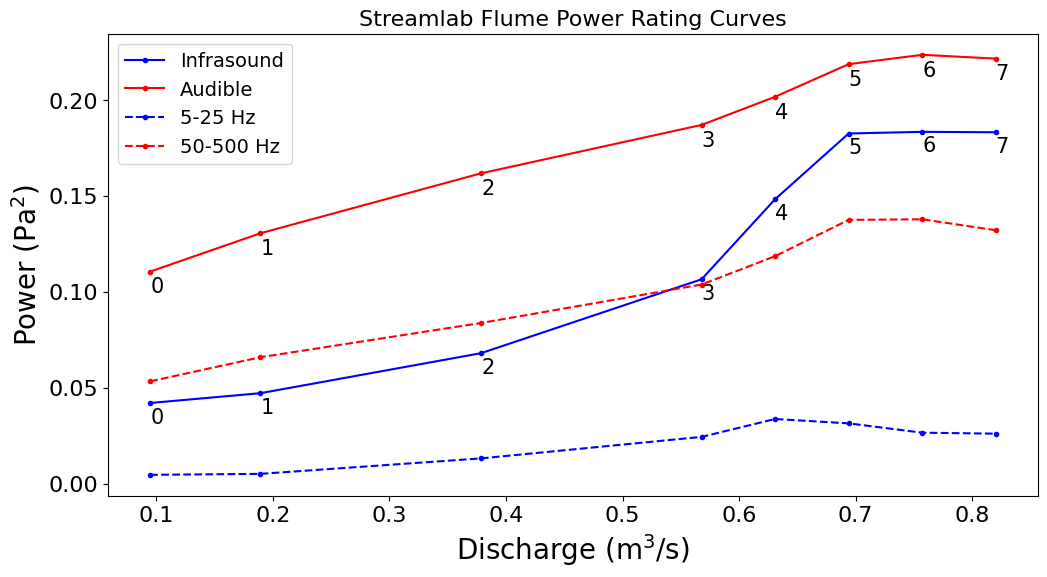

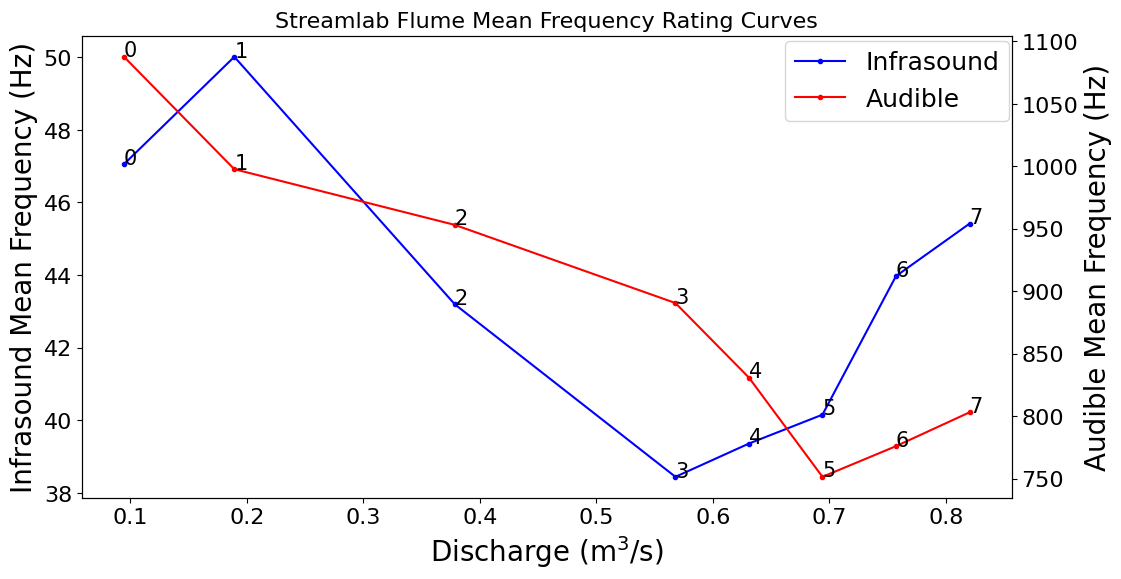

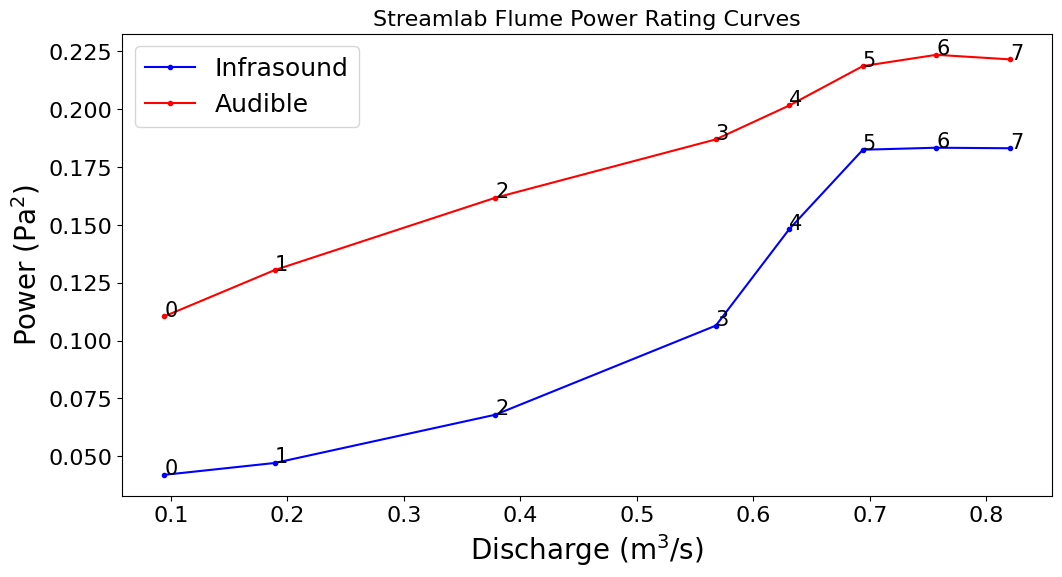

In [4]:
## reformat result lists from the loop into numpy arrays that are easy to plot
w = (freqs_infrasound_all < 100) & (freqs_infrasound_all > 3)
freqs_infrasound = freqs_infrasound_all[w]    
meanspec_infrasound = reformat(meanspec_list_infrasound)[:,w]
medspec_infrasound = reformat(medspec_list_infrasound)[:,w]
#power_infrasound = reformat(power_infrasound)

ind =  (freqs_audible_all < 20000) & (freqs_audible_all > 101)
freqs_audible = freqs_audible_all[ind]    
meanspec_audible = reformat(meanspec_list_audible)[:,ind]
medspec_audible = reformat(medspec_list_audible)[:,ind]
#power_audible = reformat(power_audible)

# check data, plot
# plt.figure(1)
# plt.subplot(2,1,1)
# plt.loglog(freqs_audible_all,meanspec_list_audible[0]) 
# plt.subplot(2,1,2)
# plt.loglog(freqs_infrasound_all, meanspec_list_infrasound[0])
# correct beginning time axis
pdtimes_audible =  pd.to_datetime(times_audible)
t = np.array(times_audible)
indices1 = [0,1,2,3,4,5,6,7]
#indices_exp1 = [0,1,2,3]
g = pdtimes_audible.strftime('%R')
g = [g[inds] for inds in indices1]
#g_exp1 = [g[inds] for inds in indices_exp1]

plt.figure(figsize = (12,8)) # ACOUSTIC HYDROGRAPH
ax = plt.subplot(3,1,2)
plt.semilogy(g, power_audible, '+-', linewidth = 3, label = 'All Audible Frequencies')
plt.semilogy(g, power_infrasound, '+-', linewidth = 3, label = 'All Infrasound Frequencies')
plt.ylabel('Power (Pa$^2$)', fontsize = 16)
for y in infra_power_band_limit:
    plt.semilogy(g, y, '.-', linewidth = 2, label = str(infra_freqs_low) + '-' + str(infra_freqs_high) + ' Hz Band'  )
for y in aud_power_band_limit:
    plt.semilogy(g, y, '.-', linewidth = 2, label = str(aud_freqs_low) + '-' + str(aud_freqs_high) + ' Hz Band' )
plt.legend(loc= (0.58, 3*10**-3), prop={'size': 9})
plt.yticks(fontsize = 16)
#plt.xlim([g[0]], [g[-1]])
plt.xticks(range(1,len(indices1),1), fontsize = 20, labels = range(1,len(indices1),1))
plt.xticks(fontsize = 12)
plt.minorticks_off()

plt.subplot(3,1,1, sharex = ax)
plt.title('Streamlab Flume Acoustic Hydrograph', fontsize = 16)
#q = [3000,1500,1570,3000,1500,3000,6000,9000,10000,11000,12000,13000,7000,0] # gal/min and use these with aud_files[3:-1] with all .wavs back in the folder
#q = [13300, 9300, 6000, 3000, 1500, 3000, 1500, 3000, 6000, 9300, 10030, 12030, 13070, 0]
q = [1500, 3000, 6000, 9000, 10000, 11000, 12000, 13000]
q = np.array(q)
q = q/60 # gal/sec
q = q/264.15 # gal=>m^3
#plt.plot(g_exp1,q[0:4], 'k--', linewidth = 4, label = 'Experiment 1')
plt.plot(g,q, 'b.-',linewidth = 2, label = 'Experiment 2') 
plt.ylabel('Discharge (m$^3$/s)', fontsize = 16)
plt.xticks(range(0,13,1), fontsize = 20, labels = range(0,13,1))
plt.xticks(fontsize = 12)
plt.yticks(np.arange(0.1, 0.9, step=0.1),np.arange(0.1, 0.9, step=0.1), fontsize = 16)
plt.minorticks_off()
#plt.xlim([g[0]], [g[-1]])
#plt.legend(loc= (0.55, 3*10**-3), prop={'size': 12})

plt.subplot(3,1,3, sharex = ax)
riversound.image(np.log10(medspec_audible), g, freqs_audible, crosshairs = False, log_y = True)
riversound.image(np.log10(medspec_infrasound), g, freqs_infrasound, crosshairs = False, log_y = True)
plt.yticks(np.arange(5)[1:],10**np.arange(5)[1:], fontsize = 20)
plt.xticks(range(0,len(q),1), fontsize = 20, labels = range(0,len(q),1))
pdtimes_infrasound =  pd.to_datetime(times_infrasound)
#indices1 = [0,1,2,3,4,5,6,7,8,9,10,11,12]# manually chosen indices to grab 1st, 15th of every month
g = pdtimes_infrasound.strftime('%H')
g = [g[inds] for inds in indices1]
ticks = [pdtimes_infrasound[inds] for inds in indices1]
# new_tick_locs = [inds+ 0.5 for inds in indices1]
# ax.xaxis.set_major_locator(ticker.FixedLocator(new_tick_locs))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)
#plt.xlim([np.min(g)], [np.max(g)])
plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Frequency (Hz)', fontsize = 16)

import os
os.chdir('/home/scott/bender/gradschool/publication/new_figs/1-31-24_figs/')
plt.savefig(fname = '3panel_flume.jpg', format = 'jpg', bbox_inches = 'tight')
#plt.xticks(8E-2*np.arange(1,4),8E-2*np.arange(1,4), fontsize = 16) #
# indices = indices1
# power2_audible = [power_audible[z] for z in indices]
# times2_audible= pd.to_datetime(times_audible, format = '%H') # Error here
# times2_audible = [times2_audible[z] for z in indices]
# X = interp_times(times_audible, t, q)
# Y = power_audible
# for i, label in enumerate(indices1):
#     plt.text( X[i],Y[i],label, fontsize = 15)

## plot discharge vs infrasound and audible mean frequencies
# plt.figure(figsize = (12,6))
# plt.plot(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13), 'b.-')
# #plt.plot(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible, 13), 'r.-')
# plt.xlabel('Discharge (m$^3$/s)', fontsize = 20)
# plt.ylabel('Mean Frequency (Hz)', fontsize = 20)
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# plt.legend(['Infrasound', 'Audible'], fontsize = 20)
# X = interp_times(times_infrasound, t, q)
# Y = riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13)
# for i, label in enumerate(indices1):
#     plt.text( X[i],Y[i],label, fontsize = 15)

# plt.figure(figsize = (12,6))
# #plt.plot(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13), 'b.-')
# plt.plot(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible, 13), 'r.-')
# plt.xlabel('Discharge (m$^3$/s)', fontsize = 20)
# plt.ylabel('Mean Frequency (Hz)', fontsize = 20)
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# plt.legend(['Audible'], fontsize = 18)
# X = interp_times(times_audible, t, q)
# Y = riversound.find_mean_freq(meanspec_audible, freqs_audible, 13)
# for i, label in enumerate(indices1):
#     plt.text( X[i],Y[i],label, fontsize = 15)

# experiment 1
# plt.figure(figsize = (12,6))
# plt.plot(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13), 'b.-')
# #plt.plot(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible, 13), 'r.-')
# plt.xlabel('Discharge (m$^3$/s)', fontsize = 20)
# plt.ylabel('Mean Frequency (Hz)', fontsize = 20)
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# plt.legend(['Infrasound', 'Audible'], fontsize = 20)
# X = interp_times(times_infrasound, t, q)
# Y = riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13)
# for i, label in enumerate(indices1):
#     plt.text( X[i],Y[i],label, fontsize = 15)
    
# plt.figure(figsize = (12,6))
# plt.plot(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13), 'b.-')
# #plt.plot(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible, 13), 'r.-')
# plt.xlabel('Discharge (m$^3$/s)', fontsize = 20)
# plt.ylabel('Mean Frequency (Hz)', fontsize = 20)
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# plt.legend(['Infrasound', 'Audible'], fontsize = 20)
# X = interp_times(times_infrasound, t, q)
# Y = riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13)
# for i, label in enumerate(indices1):
#     plt.text( X[i],Y[i],label, fontsize = 15)

plt.figure(figsize = (12,6))
plt.plot(interp_times(times_infrasound, t, q), power_infrasound, 'b.-')
plt.plot(interp_times(times_audible, t, q), power_audible, 'r.-')
plt.plot(interp_times(times_infrasound, t, q), infra_power_band_limit[0], 'b--.', label = str(infra_freqs_low) + '-' + str(infra_freqs_high) + ' Hz Band' )
plt.plot(interp_times(times_audible, t, q), aud_power_band_limit[0], 'r--.', label = str(aud_freqs_low) + '-' + str(aud_freqs_high) + ' Hz Band' )
plt.xlabel('Discharge (m$^3$/s)', fontsize = 20)
plt.ylabel('Power (Pa$^2$)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(['Infrasound', 'Audible', '5-25 Hz', '50-500 Hz'], fontsize = 14)
plt.title('Streamlab Flume Power Rating Curves', fontsize = 16)
X = interp_times(times_audible, t, q)
Y = power_audible
Z = power_infrasound
for i, label in enumerate(indices1):
    plt.text( X[i],Y[i]-np.min(Y)/10,label, fontsize = 15)
    plt.text( X[i],Z[i]-np.min(Z)/4,label, fontsize = 15)

# experiment 2: first plot mean frequencies with 2 y axes
fig, ax1 = plt.subplots(figsize = (12,6))
ax1.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
ax1.set_ylabel('Infrasound Mean Frequency (Hz)', fontsize = 20)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.plot(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound), 'b.-', label = 'Infrasound')
#ax1.plot(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound[indices_infra], 13), 'b--.')
ax2 = ax1.twinx()
ax2.plot(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible), 'r.-', label = 'Audible')
#ax2.plot(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible[indices_aud], 13), 'r--.')
ax2.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
ax2.set_ylabel('Audible Mean Frequency (Hz)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Streamlab Flume Mean Frequency Rating Curves', fontsize = 16)
fig.legend(fontsize = 18, loc= (0.7, 0.79))
#ax2.legend(['Audible'], fontsize = 18, loc= (0.25, 0.8))

indices_meanfreq = [0,1,3,4,5,6,7]
X = interp_times(times_audible, t, q)
index_q = np.array(interp_times(times_audible,t,q))[indices_meanfreq]
#X2 = interp_times(times_infrasound, t, q)[4:]
Y = np.array(riversound.find_mean_freq(meanspec_audible, freqs_audible))
Z = riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound)
for i, label in enumerate(indices1):
    ax1.text( X[i],Z[i],label, fontsize = 15)
for i, label in enumerate(indices1):
    ax2.text(X[i],Y[i]+0.15,label, fontsize = 15)

os.chdir('/home/scott/bender/gradschool/publication/new_figs/1-31-24_figs/')
fig.savefig(fname = 'freq_flume.jpg', format = 'jpg', bbox_inches = 'tight')
# fig, ax22 = plt.subplots(figsize = (12,6))
# ax22.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
# ax22.set_ylabel('Mean Frequency (Hz)', fontsize = 20)
# ax22.plot(interp_times(times_infrasound, t, q), riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13), 'b.-')
# ax3 = ax22.twinx()
# ax3.plot(interp_times(times_audible, t, q), riversound.find_mean_freq(meanspec_audible, freqs_audible, 13), 'r.-')
# ax3.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
# ax3.set_ylabel('Mean Frequency (Hz)', fontsize = 20)
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# ax22.legend(['Infrasound'],['Audible'], fontsize = 18)

# X = interp_times(times_audible, t, q)
# Y = riversound.find_mean_freq(meanspec_audible, freqs_audible, 13)
# Z = riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, 13)
# for i, label in enumerate(indices1):
#     ax3.text( X[i],Y[i],label, fontsize = 15)
#     ax22.text( X[i],Z[i],label, fontsize = 15)
    

plt.figure(figsize = (12,6))
plt.plot(interp_times(times_infrasound, t, q), power_infrasound, 'b.-')
plt.plot(interp_times(times_audible, t, q), power_audible, 'r.-')
plt.xlabel('Discharge (m$^3$/s)', fontsize = 20)
plt.ylabel('Power (Pa$^2$)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(['Infrasound', 'Audible'], fontsize = 18)
plt.title('Streamlab Flume Power Rating Curves', fontsize = 16)
X = interp_times(times_audible, t, q)
Y = power_audible
Z = power_infrasound
for i, label in enumerate(indices1):
    plt.text( X[i],Y[i],label, fontsize = 15)
    plt.text( X[i],Z[i],label, fontsize = 15)

os.chdir('/home/scott/bender/gradschool/publication/new_figs/1-31-24_figs/')
plt.savefig(fname = 'power_flume.jpg', format = 'jpg', bbox_inches = 'tight')

#plt.xticks(8E-2*np.arange(1,4),8E-2*np.arange(1,4), fontsize = 16)
#plt.yticks(5E-2*np.arange(1,5),2E4*np.arange(1,5), fontsize = 16)

## plot discharge vs sound power
# plt.figure(figsize = (12,6))
#  ## plot the 1:1 line
# X2 = (interp_times(times_audible, t, q)) # discharge
# Y2 = power_audible
# X2 = np.array([0.03101, 0.107]) # span of discharge values
# plt.loglog(X2, X2*0.00181447, 'k--') # point y value/x value times X2
# #plt.loglog(interp_times(times_infrasound, t, q), power_infrasound, 'b.-')
# plt.loglog(interp_times(times_audible, t, q), power_audible, 'r.-')
# plt.xlabel('Discharge (m$^3$/s)', fontsize = 26)
# plt.ylabel('Power (Pa$^2$)', fontsize = 26)
# plt.xticks(4E-2*np.arange(1,4),4E-2*np.arange(1,4), fontsize = 16)
# plt.yticks(5E-5*np.arange(1,5),2E-4*np.arange(1,5), fontsize = 16)
# plt.title('Streamlab Flume Acoustic Rating Curve', fontsize = 26)
# plt.legend(['Degree 1 line','Audible'], fontsize = 26)
# plt.minorticks_off()
# # label points by date
# indices = [0,int(len(indices1)/2),-1]
# power2_audible = [power_audible[z] for z in indices]
# times2_audible = pd.to_datetime(times_audible, format = '%d', dayfirst = True)
# times2_audible = [times2_audible[z] for z in indices]
# X = interp_times(times2_audible, t, q)
# Y = power2_audible
# for i, label in enumerate(times2_audible):
#     plt.text(X[i],Y[i],label.strftime('%b %d'), fontsize = 26)
#plt.savefig('April2021Eckert_qpow.png')

In [13]:
tr_infrasound.filter?

Signature: tr_infrasound.filter(type, **options)
Docstring:
Filter the data of the current trace.

:type type: str
:param type: String that specifies which filter is applied (e.g.
    ``"bandpass"``). See the `Supported Filter`_ section below for
    further details.
:param options: Necessary keyword arguments for the respective filter
    that will be passed on. (e.g. ``freqmin=1.0``, ``freqmax=20.0`` for
    ``"bandpass"``)

.. note::

    This operation is performed in place on the actual data arrays. The
    raw data is not accessible anymore afterwards. To keep your
    original data, use :meth:`~obspy.core.trace.Trace.copy` to create
    a copy of your trace object.
    This also makes an entry with information on the applied processing
    in ``stats.processing`` of this trace.

.. rubric:: _`Supported Filter`

``'bandpass'``
    Butterworth-Bandpass (uses :func:`obspy.signal.filter.bandpass`).

``'bandstop'``
    Butterworth-Bandstop (uses :func:`obspy.signal.filter.bandstop`).

In [12]:
## FIT POLYNOMIAL TO DATA: https://machinelearningmastery.com/curve-fitting-with-python/
# x: discharge y: power/freq
from matplotlib import pyplot
from scipy.optimize import curve_fit

Q_infra = interp_times(times_infrasound, t, q)
Q_aud = interp_times(times_audible, t, q)
meanfreq_infra = riversound.find_mean_freq(meanspec_infrasound, freqs_infrasound, )
meanfreq_aud = riversound.find_mean_freq(meanspec_audible, freqs_audible)

x = Q_infra
y = power_infrasound

def rating_curve_fit(degree, x, y, ylabel, s):
    if degree == 2:
        
        fig, ax1 = plt.subplots(figsize = (12,6))
        ax1.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
        if ylabel == 'Power':
            ax1.set_ylabel('Power (Pa$^2$)', fontsize = 20)
        else: 
            ax1.set_ylabel('Mean Freq (Hz)', fontsize = 20)
            
        ax1.tick_params(axis='x', labelsize=16)
        ax1.tick_params(axis='y', labelsize=16)

        def objective(x, a, b, c): # find objective function for data points 
            return a * x + b * x**2 + c

        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a, b, c = popt
        print('y = %.1f * x + %.1f * x^2 + %.1f' % (a, b, c))
        # plot input vs output
        ax1.plot(x,y, '.', label = s + ylabel)
        ax1.legend()
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(np.min(x), np.max(x), 0.01)
        # calculate the output for the range
        y_line = objective(x_line, a, b, c)
        print('y = %.1f * x + %.1f * x^2 + %.1f' % (a, b, c))
        # create a line plot for the mapping function
        ax1.plot(x_line, y_line, '--', color='red')
        ax1.legend(['y = %.1f * x + %.1f * x^2 + %.1f' % (a, b, c)], fontsize = 10, loc= (0.01, 0.9))
        ax1.legend( fontsize = 10, loc= 'best')

    if degree == 5:
        def objective(x, a, b, c, d, e, f):
            return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f
        
        fig, ax1 = plt.subplots(figsize = (12,6))
        ax1.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
        if ylabel == 'Power':
            ax1.set_ylabel('Power (Pa$^2$)', fontsize = 20)
        elif ylabel == 'Mean Freq': 
            ax1.set_ylabel('Mean Freq (Hz)', fontsize = 20)
        ax1.tick_params(axis='x', labelsize=16)
        ax1.tick_params(axis='y', labelsize=16)
        
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a, b, c, d, e, f = popt
        ax1.plot(x,y, '.', label = s + ylabel)
        ax1.legend()
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(np.min(x), np.max(x), 0.01)
        # calculate the output for the range
        y_line = objective(x_line, a, b, c, d, e, f)
        print('y = %.1f * x + %.1f * x^2 + %.1f * x^3 + %.1f * x^4 + %.1f * x^5' % (a, b, c, d, e))
        # create a line plot for the mapping function
        ax1.plot(x_line, y_line, '--', color='black', label = 'y = %.1f * x + %.1f * x^2 + %.1f * x^3 + %.1f * x^4 + %.1f * x^5' % (a, b, c, d, e))
        ax1.legend( fontsize = 10, loc= 'best')
        
    if degree == 0:
        def objective(x, a, b, c, d):
            return a * np.sin(b - x) + c * x**2 + d
        
        fig, ax1 = plt.subplots(figsize = (12,6))
        ax1.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
        
        if ylabel == 'Power':
            ax1.set_ylabel('Power (Pa$^2$)', fontsize = 20)
        elif ylabel == 'Mean Freq': 
            ax1.set_ylabel('Mean Frequency (Hz)', fontsize = 20)
    
        ax1.tick_params(axis='x', labelsize=16)
        ax1.tick_params(axis='y', labelsize=16)
        
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a, b, c, d = popt
        print(popt)
        # plot input vs output
        ax1.plot(x,y, '.', label =  s + ylabel)
        ax1.legend()
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(np.min(x), np.max(x), 0.01)
        # calculate the output for the range
        y_line = objective(x_line, a, b, c, d)
        # create a line plot for the mapping function
        ax1.plot(x_line, y_line, '--', color='red', label = ['y = %.1f * sin(%.5f - x) + %.1f * x^2 + %.1f' % (a, b, c, d)])
        ax1.legend( fontsize = 10, loc= 'best')
    if degree == 3:
        def objective(x, a, b, c, d):
            return (a * x) + (b * x**2) + (c * x**3) + d
        fig, ax1 = plt.subplots(figsize = (12,6))
        ax1.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
        if ylabel == 'Power':
            ax1.set_ylabel('Power (Pa$^2$)', fontsize = 20)
        elif ylabel == "Mean Freq": 
            ax1.set_ylabel('Mean Freq (Hz)', fontsize = 20)
            
        ax1.tick_params(axis='x', labelsize=16)
        ax1.tick_params(axis='y', labelsize=16)
        
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a, b, c, d = popt
        ax1.plot(x,y, '.', label =  s + ylabel)
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(np.min(x), np.max(x), 0.01)
        # calculate the output for the range
        y_line = objective(x_line, a, b, c, d)
        print('y = %.1f * x + %.1f * x^2 + %.1f * x^3 + %.1f' % (a, b, c, d))
        # create a line plot for the mapping function
        ax1.plot(x_line, y_line, '--', color='black', label = 'y = %.1f * x + %.1f * x^2 + %.1f * x^3 + %.1f' % (a, b, c, d))
        ax1.legend( fontsize = 10, loc= 'best')
    return x_line,y_line, x, y
# # define the true objective function
# def objective(x, a, b):
#     return a * x + b

# ax1.scatter(Q_infra, power_infrasound)
# # curve fit
# popt, _ = curve_fit(objective, Q_infra, power_infrasound)
# # summarize the parameter values
# a, b = popt
# print('y = %.5f * x + %.5f' % (a, b))

# x_line_infra = np.arange(min(Q_infra), max(Q_infra), 1)
# y_line_infra = objective(x_line_infra, a, b)
# ax1.plot(x_line_infra, y_line_infra, '--', color='red')


y = -2036.9 * x + 2530.4 * x^2 + 11072.6 * x^3 + -31538.8 * x^4 + 20715.0 * x^5
y = -0.2 * x + 3.0 * x^2 + -10.2 * x^3 + 14.3 * x^4 + -7.1 * x^5
y = 187.5 * x + -723.0 * x^2 + 776.5 * x^3 + 39.4 * x^4 + -278.2 * x^5
y = -0.5 * x + 4.6 * x^2 + -15.4 * x^3 + 23.2 * x^4 + -12.3 * x^5


Text(0.5, 1.0, 'Streamlab Flume Mean Frequency Rating Curves')

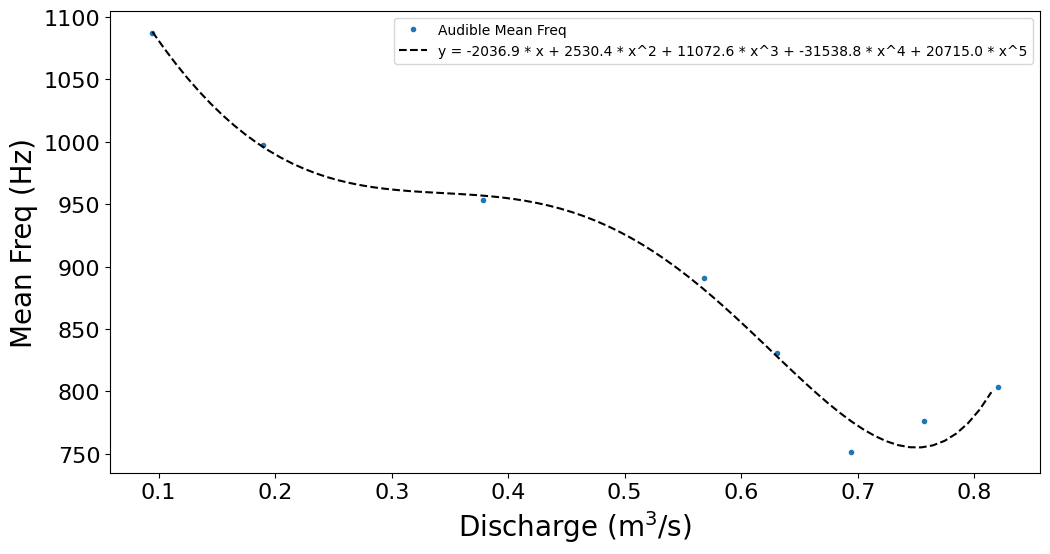

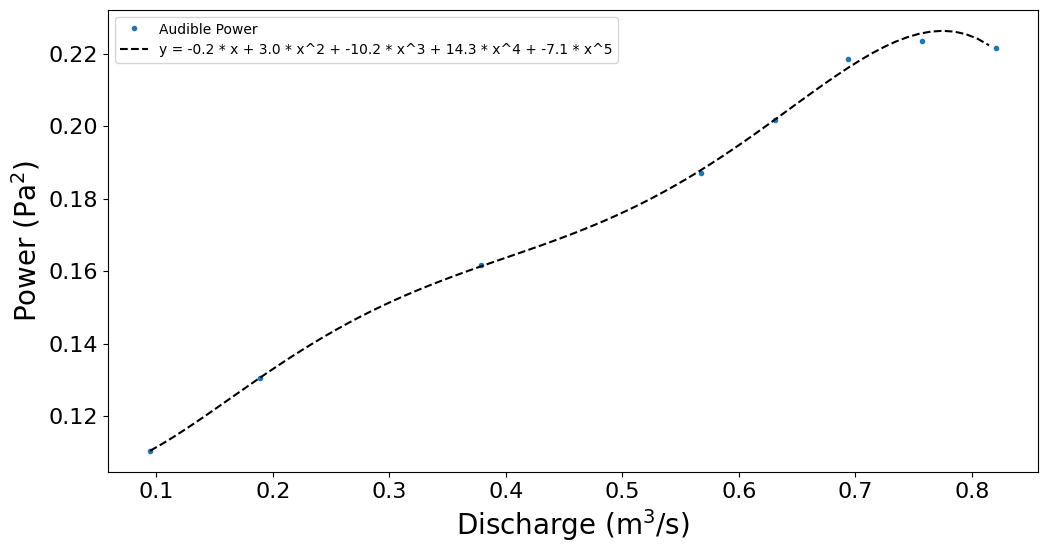

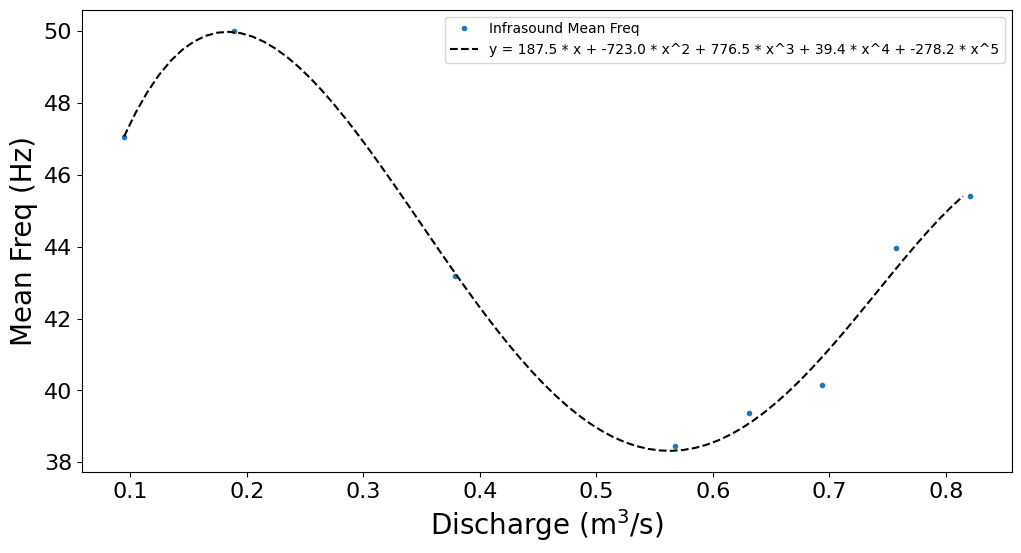

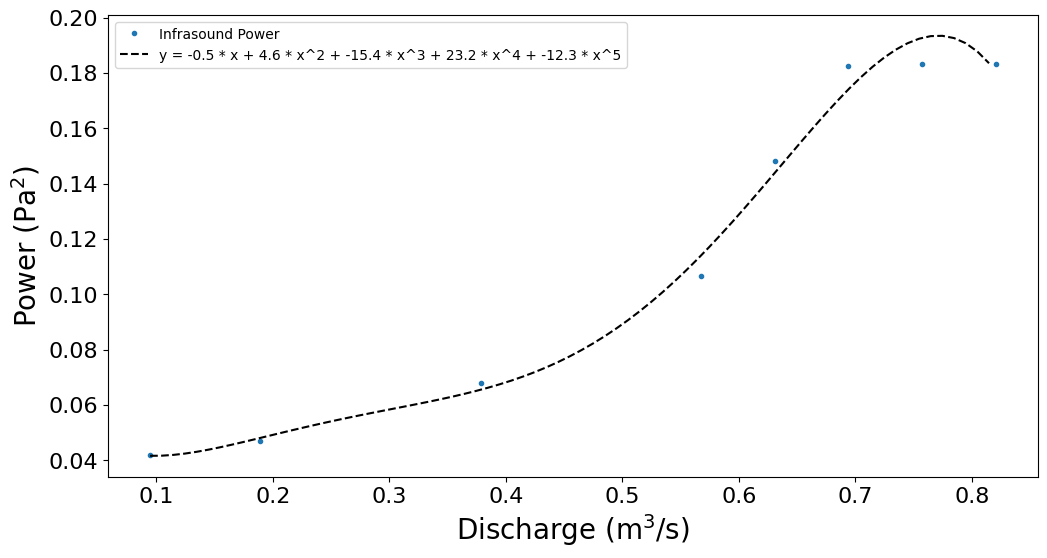

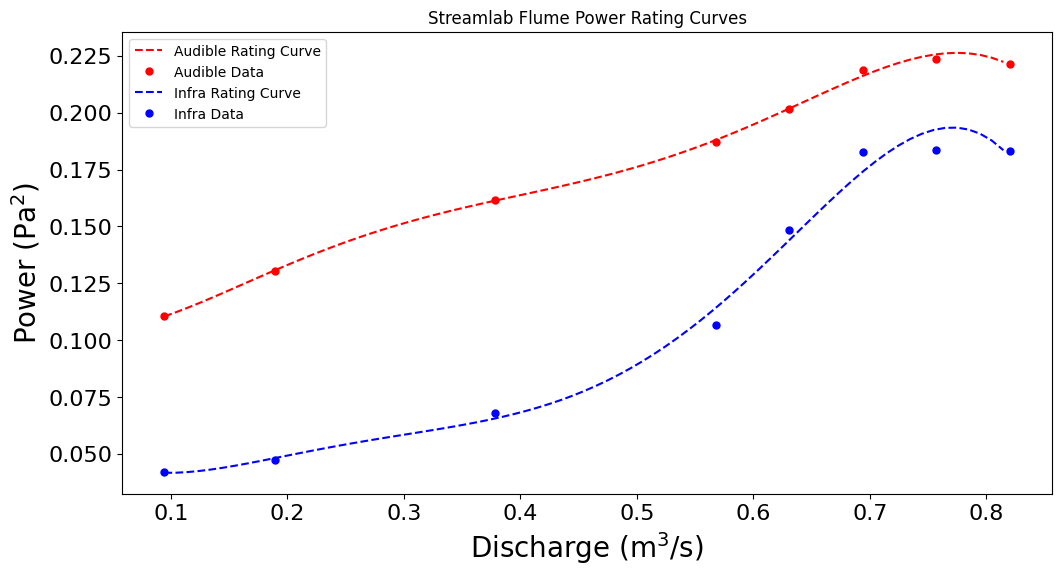

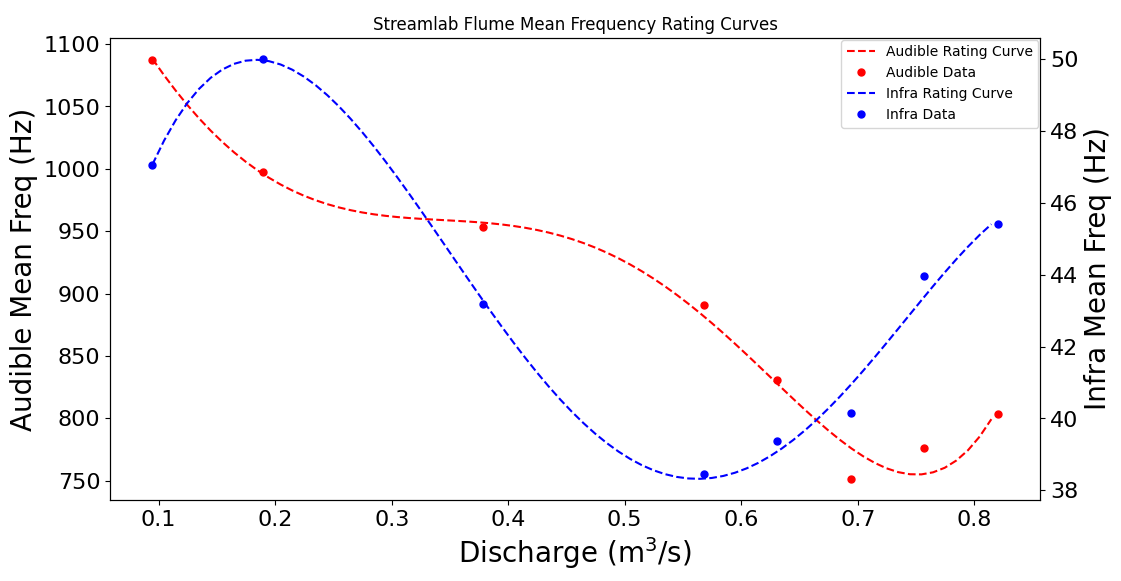

In [40]:
for degree in [5]:
    
    xline_flume_audfreq, yline_flume_audfreq, x_flume_audfreq, y_flume_audfreq = rating_curve_fit(degree, Q_aud, meanfreq_aud, ylabel = 'Mean Freq', s = 'Audible ')
    xline_flume_audpower, yline_flume_audpower, x_flume_audpower, y_flume_audpower = rating_curve_fit(degree, Q_aud, power_audible, ylabel = 'Power', s = 'Audible ' )

    xline_flume_infrafreq, yline_flume_infrafreq, x_flume_infrafreq, y_flume_infrafreq = rating_curve_fit(degree, Q_infra, meanfreq_infra, ylabel = 'Mean Freq', s = 'Infrasound ')
    xline_flume_infrapower, yline_flume_infrapower, x_flume_infrapower, y_flume_infrapower = rating_curve_fit(degree, Q_infra, power_infrasound, ylabel = 'Power', s = 'Infrasound ')

power, ax1 = plt.subplots(figsize = (12,6))
ax1.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
ax1.set_ylabel('Power (Pa$^2$)', fontsize = 20)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

ax1.plot(xline_flume_audpower, yline_flume_audpower, 'r--', label = 'Audible Rating Curve')
ax1.plot(x_flume_audpower, y_flume_audpower, 'r.', markersize = 10, label = 'Audible Data')
ax1.plot(xline_flume_infrapower, yline_flume_infrapower, 'b--', label = 'Infra Rating Curve')
ax1.plot(x_flume_infrapower, y_flume_infrapower, 'b.', markersize = 10, label = 'Infra Data')
ax1.legend()
ax1.set_title('Streamlab Flume Power Rating Curves')


freq, ax2 = plt.subplots(figsize = (12,6))
ax2.set_xlabel('Discharge (m$^3$/s)', fontsize = 20)
ax2.set_ylabel('Audible Mean Freq (Hz)', fontsize = 20)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

ax2.plot(xline_flume_audfreq, yline_flume_audfreq, 'r--', label = 'Audible Rating Curve')
ax2.plot(x_flume_audfreq, y_flume_audfreq, 'r.', markersize = 10, label = 'Audible Data')

ax3 = ax2.twinx()
ax3.plot(xline_flume_infrafreq, yline_flume_infrafreq, 'b--', label = 'Infra Rating Curve')
ax3.plot(x_flume_infrafreq, y_flume_infrafreq, 'b.', markersize = 10, label = 'Infra Data')
ax3.set_ylabel('Infra Mean Freq (Hz)', fontsize = 20)
ax3.tick_params(axis='x', labelsize=16)
ax3.tick_params(axis='y', labelsize=16)
#ax2.legend()
freq.legend(loc= (0.75,0.78))
ax2.set_title('Streamlab Flume Mean Frequency Rating Curves')

In [ ]:
equation = .5f * sin(.5f - x) + .5f * x^2 + .5f' % (a, b, c, d)